# 데이터

In [1]:
!pip install konlpy -qq

In [2]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [3]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [4]:
train_data_path ="../data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [5]:
train_data.sample(10)

,idx,class,conversation
2781,2781,기타 괴롭힘 대화,너 내욕하고 다닌다며?\n 무슨말이야? 난 안그랬어?\n 어디서 거짓말이야? 왕따주...
872,872,협박 대화,김부장\n 오셨습니까\n 내가 시킨거 어떻게 했어 ?\n 그게.\n 안했어 ?\n ...
4692,4692,갈취 대화,저기요 저 1000원만 주실 수 있나요?\n네? 제가 왜요?\n제가 버스비가 없어서...
4150,4150,기타 괴롭힘 대화,니가 나 따라한다는 애구나?\n 내가? 나 너 안따라해.\n머라는거야. 여기 사진 ...
203,203,기타 괴롭힘 대화,여어 땅끄지 어디 가냐?\n 남이사 어딜 가든 말든\n 남이라니 섭하게. 우리 친구...
289,289,갈취 대화,우와 이거 예쁘다. 머야 이거?\n엄마가 롤렉스에서 시계 사줬어.\n우와 이거 엄청...
4905,4905,기타 괴롭힘 대화,바보야 넌 이것도 모르냐?\n 모를수도 있지. 그럼 너는 다 아냐?\n 난 다 알아...
3905,3905,직장 내 괴롭힘 대화,안녕하십니까 사장님\n뭔 안녕해 미친놈아 저리 꺼져\n죄송합니다 사장님\n그러게 죄...
3746,3746,갈취 대화,야 앞보고 걸어라\n아 누구세요?\n앞에보고 걸어라했다\n네 걷고있어요\n너얼마있냐...
2832,2832,갈취 대화,야 가지고 왔냐?\n미안해. 아버지가 안 주무셔서 못가지고 나왔어.\n새끼야. 그럼...


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## Augmentation

## EDA

In [7]:
# 클래스 별 대화 확인해보기
class_counts = train_data.groupby('class').size()
class_counts

class
갈취 대화           981
기타 괴롭힘 대화      1094
일반 대화          1000
직장 내 괴롭힘 대화     979
협박 대화           896
dtype: int64

In [8]:
# 대화(X)와 레이블(y)로 나누기
X_train = train_data['conversation']
y_train = train_data['class']

#### 길이 분포 확인

In [9]:
# 길이 분포 확인하기
print('Data Information')
print('-'*50)
print('Conversations :',X_train.shape)
print('Label :',y_train.shape)
print('Label Type:', set(y_train))
print('-'*50)
num_classes = 4
print('The number of classes : {}'.format(num_classes))
print('-'*50)
print('Max Length :{}'.format(max(len(l) for l in X_train)))
print('Average Length :{}'.format(sum(map(len, X_train))/len(X_train)))

Data Information
--------------------------------------------------
Conversations : (4950,)
Label : (4950,)
Label Type: {'일반 대화', '갈취 대화', '협박 대화', '기타 괴롭힘 대화', '직장 내 괴롭힘 대화'}
--------------------------------------------------
The number of classes : 4
--------------------------------------------------
Max Length :874
Average Length :232.0210101010101


#### 클래스 별 분포 확인

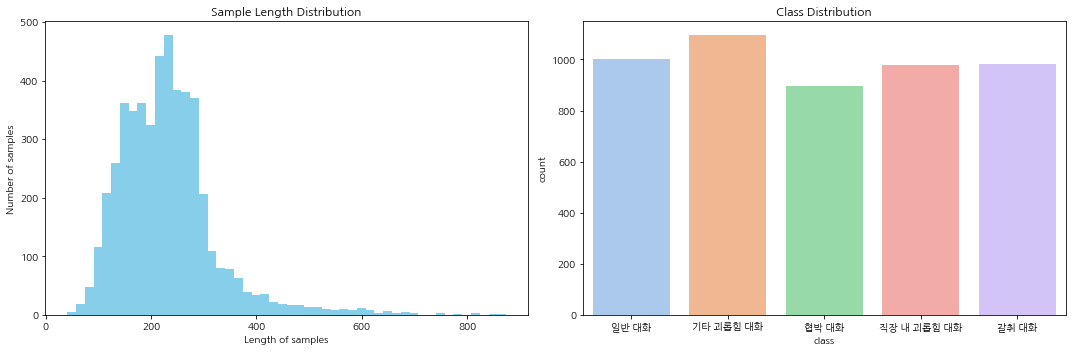

In [10]:
# 두 서브플롯 생성하기
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# 샘플 길이의 히스토그램
axes[0].hist([len(s) for s in X_train], bins=50, color='skyblue')
axes[0].set_xlabel('Length of samples')
axes[0].set_ylabel('Number of samples')
axes[0].set_title('Sample Length Distribution')

# 클래스별 샘플 수 플롯
sns.countplot(x=y_train, ax=axes[1], palette='pastel')
axes[1].set_title('Class Distribution')

# 레이아웃 조정하기
plt.tight_layout()

# 플롯 표시하기
plt.show()

#### 클래스 별 길이 분포 확인

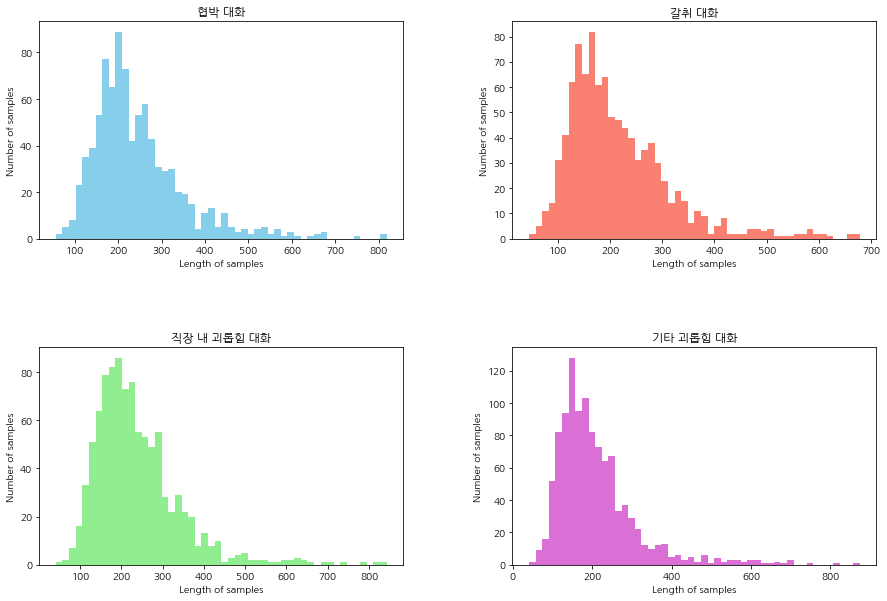

In [11]:
# 서브플롯 생성하기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# 샘플 길이의 히스토그램 그리기

# 협박 대화
axes[0][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='협박 대화']],
                bins=50, color='skyblue')
axes[0][0].set_xlabel('Length of samples')
axes[0][0].set_ylabel('Number of samples')
axes[0][0].set_title('협박 대화')

# 갈취 대화
axes[0][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='갈취 대화']],
                bins=50, color='salmon')
axes[0][1].set_xlabel('Length of samples')
axes[0][1].set_ylabel('Number of samples')
axes[0][1].set_title('갈취 대화')

# 직장 내 괴롭힘 대화
axes[1][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='직장 내 괴롭힘 대화']],
                bins=50, color='lightgreen')
axes[1][0].set_xlabel('Length of samples')
axes[1][0].set_ylabel('Number of samples')
axes[1][0].set_title('직장 내 괴롭힘 대화')

# 기타 괴롭힘 대화
axes[1][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='기타 괴롭힘 대화']],
                bins=50, color='orchid')
axes[1][1].set_xlabel('Length of samples')
axes[1][1].set_ylabel('Number of samples')
axes[1][1].set_title('기타 괴롭힘 대화')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

#### 화자 별 특징 분석

In [12]:
# A와 B의 대화를 담을 리스트 초기화하기
A_conversations = []
B_conversations = []

In [13]:
# 대화 열을 반복하면서 각 대화를 분할하기
for conversation in train_data['conversation']:
    try:
        lines = conversation.split('\n')
        # 홀수 줄은 A, 짝수 줄은 B에 추가하기
        A_conv = '\n'.join([line for idx, line in enumerate(lines) if idx % 2 == 0])
        B_conv = '\n'.join([line for idx, line in enumerate(lines) if idx % 2 == 1])
        A_conversations.append(A_conv)
        B_conversations.append(B_conv)
    except ValueError:
        # 대화가 정확히 두 부분으로 나뉘지 않는 경우 처리하기
        A_conversations.append(conversation)
        B_conversations.append('')

In [14]:
# A와 B를 위한 새로운 데이터프레임 생성하기
A_data = pd.DataFrame({'idx': train_data['idx'], 'class': train_data['class'], 'conversation': A_conversations})
B_data = pd.DataFrame({'idx': train_data['idx'], 'class': train_data['class'], 'conversation': B_conversations})

In [15]:
# A의 head() 출력하기
print("A 데이터셋의 첫 5개 행:")
A_data.head()

A 데이터셋의 첫 5개 행:


,idx,class,conversation
0,0,일반 대화,학교 점심 뭐 나와?\n학원 다녀?\n친구들이랑 잘 지내?\n교복은 어때?\n교복은...
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?\n네 ...
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 나와 이 자식아. 미안하단 말도 없는 ...
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n팀에서 내가 니가가 어딨어?\n이번 인사고과기간인거...
4,4,일반 대화,비가 많이 오네.\n날씨가 추워졌어.\n바람이 많이 불어.\n날씨가 추워졌어.\n날...


In [16]:
# B의 head() 출력하기
print("B 데이터셋의 첫 5개 행:")
B_data.head()

B 데이터셋의 첫 5개 행:


,idx,class,conversation
0,0,일반 대화,"주로 한식이 나와.\n응, 영어 학원 다녀.\n응, 다들 친절해.\n생각보다 편해...."
1,1,기타 괴롭힘 대화,나?\n놀리지마\n그 따위로 말하지 말라고\n나도 이름 있어\n자꾸 그렇게 대꾸하지마
2,2,협박 대화,뭐라구?\n 이 새끼가 어디서.\n 이런 쓰레기를 봤나\n 꺼져 새꺄\n 보자보자...
3,3,직장 내 괴롭힘 대화,이거 제가 한게 아닌데요\n그래도 이건 제가 쓴게 아닌데 \n네? 아니 이건 제가 ...
4,4,일반 대화,"우산 가져왔어?\n맞아, 이제 겨울이야.\n모자 날아갈 뻔했어.\n맞아, 이제 겨울..."


In [17]:
# Okt 토크나이저 활용하여 단어 추출
okt=Okt()

In [18]:
# 가장 많이 나오는 단어 추출하는 함수
def get_top_words(dataframe, class_name, top_n=10):
    # 특정 클래스의 대화만 추출하기
    class_data = dataframe[dataframe['class'] == class_name]['conversation']
    words = []

    for conversation in class_data:
        words.extend([word for word in okt.nouns(conversation)])

    # 가장 많이 등장하는 단어 top_n 추출하기
    counter = Counter(words)
    common_words = counter.most_common(top_n)
    return common_words

In [19]:
# 가장 많이 나오는 단어 시각화하는 함수
def plot_top_words(common_words_A, common_words_B, class_name):
    words_A, counts_A = zip(*common_words_A)
    words_B, counts_B = zip(*common_words_B)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

    axes[0].bar(words_A, counts_A, color=plt.cm.Paired.colors)
    axes[0].set_title(f'Top {len(words_A)} Words in Class {class_name} (A)')
    axes[0].set_xlabel('Words')
    axes[0].set_ylabel('Counts')

    axes[1].bar(words_B, counts_B, color=plt.cm.Paired.colors)
    axes[1].set_title(f'Top {len(words_B)} Words in Class {class_name} (B)')
    axes[1].set_xlabel('Words')
    axes[1].set_ylabel('Counts')

    plt.show()

In [20]:
# 클래스 목록 추출하기
classes = train_data['class'].unique()

Class: 일반 대화
A 데이터셋의 상위 10개 단어:
[('뭐', 1782), ('친구', 1071), ('해', 952), ('영화', 943), ('여행', 909), ('자주', 646), ('거', 640), ('운동', 601), ('가족', 599), ('주말', 508)]

B 데이터셋의 상위 10개 단어:
[('응', 4621), ('주로', 934), ('정말', 709), ('해', 621), ('영화', 618), ('주말', 522), ('나', 413), ('친구', 369), ('다음', 340), ('집', 337)]


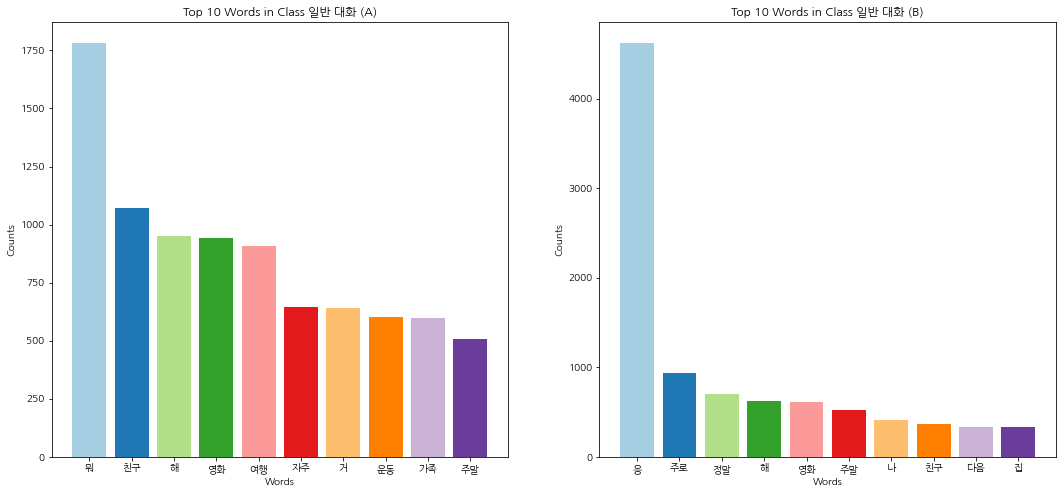

Class: 기타 괴롭힘 대화
A 데이터셋의 상위 10개 단어:
[('너', 1169), ('내', 461), ('왜', 452), ('좀', 398), ('말', 387), ('뭐', 348), ('나', 346), ('거', 335), ('니', 312), ('진짜', 259)]

B 데이터셋의 상위 10개 단어:
[('왜', 461), ('나', 453), ('너', 440), ('내', 418), ('말', 385), ('네', 301), ('뭐', 259), ('진짜', 220), ('좀', 200), ('거', 190)]


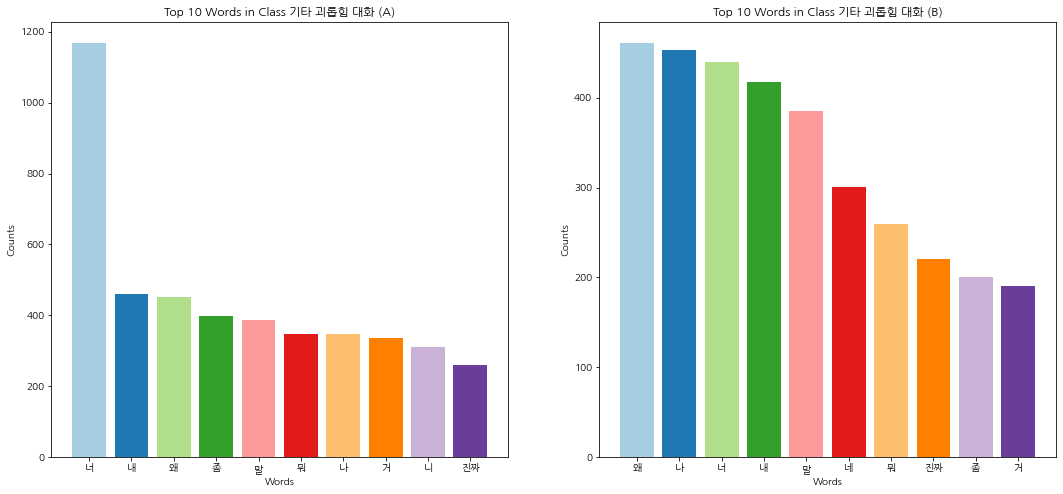

Class: 협박 대화
A 데이터셋의 상위 10개 단어:
[('너', 1077), ('내', 850), ('말', 462), ('니', 407), ('나', 405), ('이', 278), ('지금', 267), ('왜', 255), ('거', 238), ('진짜', 190)]

B 데이터셋의 상위 10개 단어:
[('내', 461), ('너', 442), ('왜', 366), ('제발', 354), ('나', 283), ('말', 260), ('네', 259), ('제', 200), ('뭐', 178), ('니', 173)]


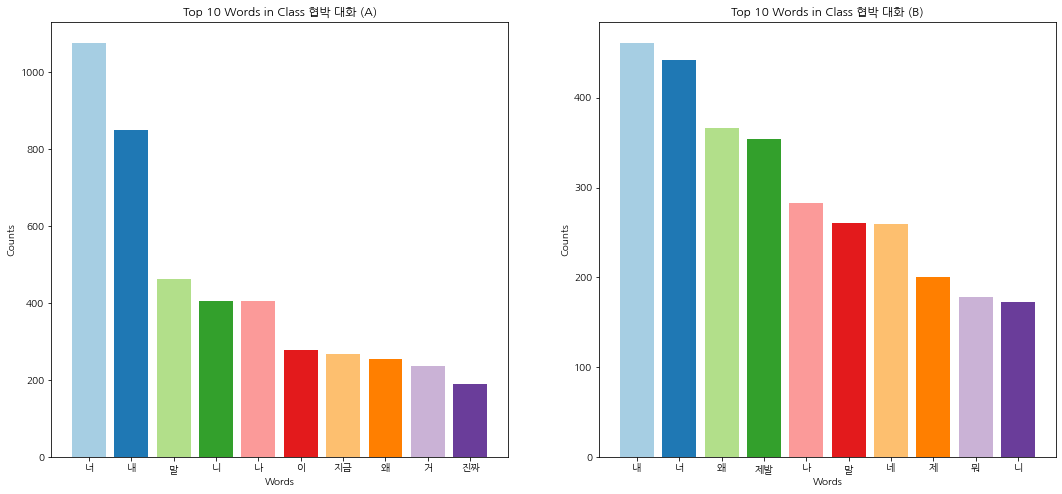

Class: 직장 내 괴롭힘 대화
A 데이터셋의 상위 10개 단어:
[('내', 571), ('좀', 464), ('너', 422), ('말', 408), ('뭐', 367), ('일', 363), ('거', 350), ('대리', 325), ('회사', 314), ('왜', 279)]

B 데이터셋의 상위 10개 단어:
[('네', 988), ('제', 388), ('저', 361), ('왜', 204), ('부장', 203), ('것', 186), ('일', 180), ('말', 173), ('지금', 144), ('회사', 141)]


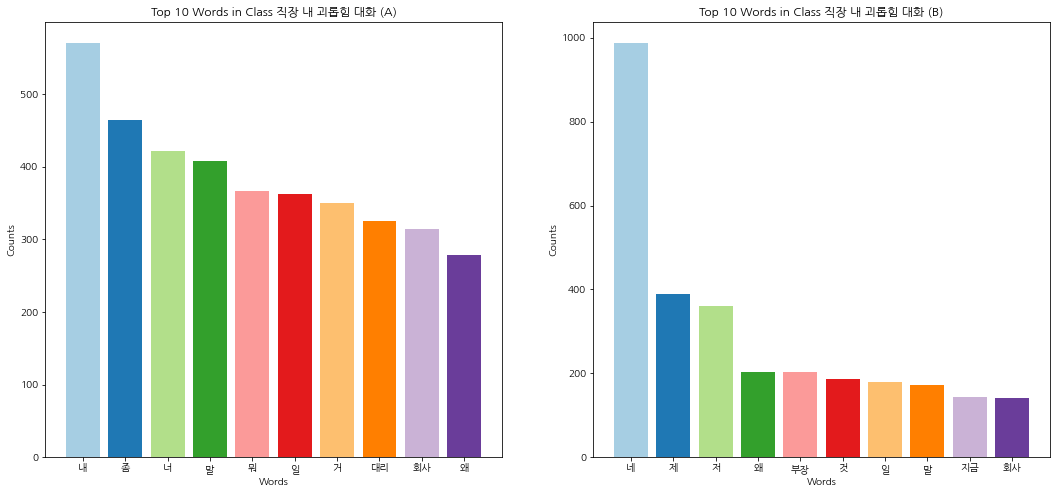

Class: 갈취 대화
A 데이터셋의 상위 10개 단어:
[('돈', 876), ('너', 797), ('내', 684), ('나', 560), ('좀', 501), ('거', 448), ('말', 314), ('이', 247), ('니', 236), ('지금', 232)]

B 데이터셋의 상위 10개 단어:
[('돈', 606), ('네', 439), ('왜', 358), ('저', 332), ('거', 292), ('진짜', 283), ('내', 278), ('나', 268), ('제발', 197), ('말', 174)]


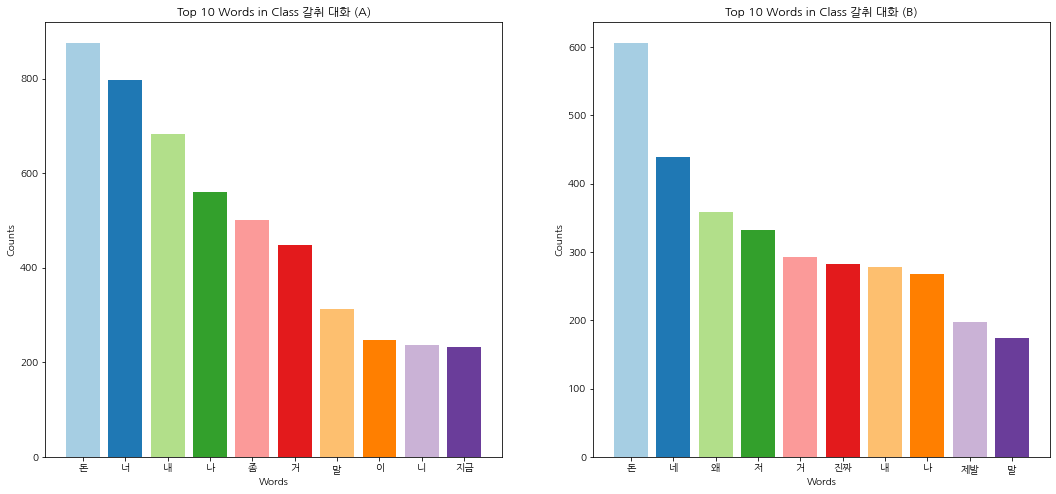

In [21]:
# 각 클래스별로 시각화
for class_name in classes:
    print(f"Class: {class_name}")
    print("A 데이터셋의 상위 10개 단어:")
    top_words_A = get_top_words(A_data, class_name)
    print(top_words_A)

    print("\nB 데이터셋의 상위 10개 단어:")
    top_words_B = get_top_words(B_data, class_name)
    print(top_words_B)

    plot_top_words(top_words_A, top_words_B, class_name)

## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [22]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


중복값 없음

#### 결측치 여부 확인하기

In [23]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

결측치 없음

#### 클래스 컬럼 인코딩하기

In [24]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [25]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [26]:
# type 열 추가했는지 확인하기
train_data.head()

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [27]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
new_train_data.head()

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [28]:
# new_train_data를 train_data에 덮어 씌우기
train_data = new_train_data

### 텍스트 전처리

#### 한글 외 문자 삭제
한글, '?', '!', '.', '.', 공백 유지

In [29]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [30]:
# 전처리 데이터 새로운 column에 저장
train_data['preprocessed'] = train_data['conversation'].apply(preprocess_sentence)

train_data['preprocessed']

# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['preprocessed']
train_data.drop('preprocessed', axis=1)

,conversation,type
0,"학교 점심 뭐 나와 ? 주로 한식이 나와 . 학원 다녀 ? 응 , 영어 학원...",4
1,어이 거기 뒤뚱거리는 놈 나 ? 그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...,3
2,너 그따위로 운전하면 확 갈아마셔버린다 . 뭐라구 ? 나와 이 자식아 . ...,0
3,길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...,2
4,"비가 많이 오네 . 우산 가져왔어 ? 날씨가 추워졌어 . 맞아 , 이제 겨울...",4
...,...,...
4945,오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...,0
4946,이거 니 주민등록증 아니야 ? 잃어버린줄 알았는데 . 고마워 ! 고맙긴 뭘 근데...,1
4947,"여행 준비 다 했어 ? 아직 , 짐 싸는 중이야 . 여행 가방은 다 쌌어 ? ...",4
4948,그거 사줘 안사주면 죽어버릴거야 이러지마 돈없어 나한테 해준게 뭐있어 ! ! ...,0


#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [31]:
# 불용어 리스트 불러오기
stopwords_path = "ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

In [32]:
## 시작 토큰, 종료 토큰 추가
SPECIAL_TOKENS = ('<pad>', '<unk>', '<sos>', '<eos>')

In [33]:
def tokenizing_df(train_data,
                 special_tokens = SPECIAL_TOKENS,
                 ):
    # Okt로 토큰화
    tokenizer=Okt()
    #tokenizer=Mecab()

    def tokenize(conversation, tokenizer):
        return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

    # 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
    tokenized = train_data['conversation'].apply(lambda x: tokenize(x, tokenizer))

    # 시작 토큰과 종료 토큰을 추가하는 함수 정의
    def add_special_tokens(tokens):
        return [special_tokens[2]] + tokens + [special_tokens[3]]

    # 'tokenized' 열에 함수 적용하여 시작 토큰과 종료 토큰 추가
    return tokenized.apply(add_special_tokens)

In [34]:
train_data['tokenized'] = tokenizing_df(train_data)

---

In [37]:
# vocabulary 파일로 저장
word_to_index_path = './vocab.json'
import json
def save_counter(counter):
    with open(word_to_index_path, 'w') as f:
        res = {word: idx for idx, (word, _) in enumerate(counter)}
        json.dump(counter, f)

def load_counter(word_to_index_path):
    with open(word_to_index_path, 'r') as f:
        return json.load(f)

# ## 단어사전 생성
# # 'tokenized' 열의 모든 토큰을 모아 등장 빈도 계산
# all_tokens = [token for tokens in train_data['tokenized'] for token in tokens]
# counter = Counter(all_tokens)
# # 가장 많이 등장하는 단어 vocab_size 개수만큼 남기기
# counter = counter.most_common(VOCAB_SIZE)
    
# save_counter(counter)
counter = load_counter(word_to_index_path)

In [38]:
word_to_index = {token: idx for idx, token in enumerate(SPECIAL_TOKENS[:2])}
word_to_index.update({token: idx + len(SPECIAL_TOKENS[:2]) for idx, (token, _) in enumerate(counter)})

In [39]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=len(word_to_index)
print(VOCAB_SIZE)

20002


#### 정수인코딩

In [40]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

train_data['encoded'] = train_data['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

## 전처리 후 분석

#### 토큰화된 데이터 길이 확인

최대 길이: 311
최소 길이: 14
평균 길이: 77.63575757575758
표준편차: 31.53093869760893


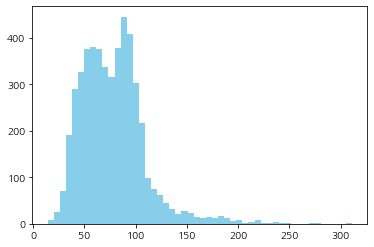

In [41]:
# 'encoded' 열의 각 리스트의 길이 계산
lengths = train_data['encoded'].apply(len)

print(f"최대 길이: {lengths.max()}")
print(f"최소 길이: {lengths.min()}")
print(f"평균 길이: {lengths.mean()}")
print(f"표준편차: {lengths.std()}")

# 길이 분포 시각화
plt.hist(lengths, bins=50, color='skyblue')
plt.show()

#### 패딩 적용

In [42]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

## 데이터 분할

In [43]:
X = pad_sequences(train_data['encoded'].tolist(), maxlen=MAX_LENGTH, padding='post', truncating='post')
y = train_data['type'].values
CLS_NUM = y.max() + 1

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

훈련 데이터의 개수 : 3960
훈련 레이블의 개수 : 3960
검증 데이터의 개수 : 495
검증 레이블의 개수 : 495
테스트 데이터의 개수 : 495
테스트 레이블의 개수 : 495


# 모델링

In [44]:
!pip install wandb==0.16.0 -qq

In [45]:
import wandb
from wandb.keras import WandbCallback

wandb.login(key = '746fb761ab2f1b53db2dafef7340caad69224513')

wandb: Currently logged in as: hojae-choi (aiffel_minions). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [46]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [47]:
from  tensorflow import keras
def build_model(config):
    model=keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.GRU(units = config.units_1, return_sequences = True))
    model.add(keras.layers.GRU(units = config.units_2))
    model.add(keras.layers.Dense(config.units_3, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))

    return model
    

In [48]:

class Config(dict):
    def __init__(self, *args, **kwargs):
        super(Config, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [54]:
import tensorflow_addons as tfa
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report
    )


def train():
    default_config = {
        "vocab" : VOCAB_SIZE,
        "embeddings" : 64,
        "units_1" : 256,
        "units_2" : 256,
        "units_3" : 1024,
        "class_num" : CLS_NUM,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 10,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config
#     config = Config(default_config)

    # Model
    keras.backend.clear_session()
    model = build_model(config)

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.
    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    history = model.fit(X_train, y_train,
              epochs = config.epoch,
              shuffle=True,
              batch_size = config.batch_size,
              validation_data = (X_val, y_val),
              callbacks = [WandbCallback()],
             )
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    pred_test = model.predict(X_test).argmax(axis=1)
    f1_score_res = f1_score(y_test, pred_test, average='micro')
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.

    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test F1 Score: ": round(f1_score_res * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})
    return history

In [55]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'hojae-choi',
                       project = 'DLthon')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: cana3il6
Sweep URL: https://wandb.ai/hojae-choi/DLthon/sweeps/cana3il6


wandb: Agent Starting Run: 6hvlk7d5 with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.06828226660446221


Epoch 1/7
124/124 [==============================] - 7s 25ms/step - loss: 4.0185 - accuracy: 0.2164 - val_loss: 1.6264 - val_accuracy: 0.1838


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050612-6hvlk7d5/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050612-6hvlk7d5/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050612-6hvlk7d5/files/model-best)... Done. 0.1s


Epoch 2/7
124/124 [==============================] - 3s 20ms/step - loss: 1.6691 - accuracy: 0.2023 - val_loss: 1.6000 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050612-6hvlk7d5/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050612-6hvlk7d5/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050612-6hvlk7d5/files/model-best)... Done. 0.1s


Epoch 3/7
124/124 [==============================] - 2s 20ms/step - loss: 1.6487 - accuracy: 0.2053 - val_loss: 1.6022 - val_accuracy: 0.2667
Epoch 4/7
124/124 [==============================] - 2s 18ms/step - loss: 1.6142 - accuracy: 0.2053 - val_loss: 1.6259 - val_accuracy: 0.1636
Epoch 5/7
124/124 [==============================] - 2s 18ms/step - loss: 1.6332 - accuracy: 0.1982 - val_loss: 1.6115 - val_accuracy: 0.1838
Epoch 6/7
124/124 [==============================] - 2s 19ms/step - loss: 1.6130 - accuracy: 0.2121 - val_loss: 1.6124 - val_accuracy: 0.1838
Epoch 7/7
124/124 [==============================] - 2s 19ms/step - loss: 1.6126 - accuracy: 0.2030 - val_loss: 1.6255 - val_accuracy: 0.1636
16/16 - 0s - loss: 1.6139 - accuracy: 0.1798


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test F1 Score:,▁
accuracy,█▃▄▄▁▆▃
epoch,▁▂▃▅▆▇█
loss,█▁▁▁▁▁▁
val_accuracy,▂██▁▂▂▁
val_loss,█▁▂█▄▄█
Test Accuracy Rate:,17.98
Test Error Rate:,82.02
Test F1 Score:,17.98


wandb: Agent Starting Run: ddocvidv with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.02504365529089586


Epoch 1/9
124/124 [==============================] - 7s 24ms/step - loss: 2.7639 - accuracy: 0.1947 - val_loss: 1.6048 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050703-ddocvidv/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050703-ddocvidv/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050703-ddocvidv/files/model-best)... Done. 0.1s


Epoch 2/9
124/124 [==============================] - 3s 20ms/step - loss: 1.6100 - accuracy: 0.2136 - val_loss: 1.6015 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050703-ddocvidv/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050703-ddocvidv/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050703-ddocvidv/files/model-best)... Done. 0.1s


Epoch 3/9
124/124 [==============================] - 3s 20ms/step - loss: 1.6109 - accuracy: 0.2003 - val_loss: 1.6060 - val_accuracy: 0.1838
Epoch 4/9
124/124 [==============================] - 2s 19ms/step - loss: 1.6104 - accuracy: 0.2063 - val_loss: 1.6069 - val_accuracy: 0.1838
Epoch 5/9
124/124 [==============================] - 2s 19ms/step - loss: 1.6100 - accuracy: 0.2124 - val_loss: 1.6051 - val_accuracy: 0.2667
Epoch 6/9
124/124 [==============================] - 2s 19ms/step - loss: 1.6104 - accuracy: 0.2114 - val_loss: 1.5986 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050703-ddocvidv/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050703-ddocvidv/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050703-ddocvidv/files/model-best)... Done. 0.1s


Epoch 7/9
124/124 [==============================] - 3s 20ms/step - loss: 1.6109 - accuracy: 0.2098 - val_loss: 1.6070 - val_accuracy: 0.1636
Epoch 8/9
124/124 [==============================] - 2s 18ms/step - loss: 1.6108 - accuracy: 0.2078 - val_loss: 1.6121 - val_accuracy: 0.1838
Epoch 9/9
124/124 [==============================] - 2s 19ms/step - loss: 1.6104 - accuracy: 0.2078 - val_loss: 1.6058 - val_accuracy: 0.2667
16/16 - 0s - loss: 1.6150 - accuracy: 0.2323


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test F1 Score:,▁
accuracy,▁█▃▅█▇▇▆▆
epoch,▁▂▃▄▅▅▆▇█
loss,█▁▁▁▁▁▁▁▁
val_accuracy,██▂▂██▁▂█
val_loss,▄▂▅▅▄▁▅█▅
Test Accuracy Rate:,23.23
Test Error Rate:,76.77
Test F1 Score:,23.23


wandb: Agent Starting Run: v5n8xoyz with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.04320534923773999


Epoch 1/8
124/124 [==============================] - 7s 34ms/step - loss: 9.5057 - accuracy: 0.2086 - val_loss: 1.6078 - val_accuracy: 0.1636


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best)... Done. 0.1s


Epoch 2/8
124/124 [==============================] - 2s 20ms/step - loss: 1.6106 - accuracy: 0.2045 - val_loss: 1.6075 - val_accuracy: 0.2182


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best)... Done. 0.1s


Epoch 3/8
124/124 [==============================] - 2s 20ms/step - loss: 1.6115 - accuracy: 0.2073 - val_loss: 1.6053 - val_accuracy: 0.2182


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best)... Done. 0.1s


Epoch 4/8
124/124 [==============================] - 2s 20ms/step - loss: 1.6122 - accuracy: 0.2083 - val_loss: 1.6158 - val_accuracy: 0.1636
Epoch 5/8
124/124 [==============================] - 2s 19ms/step - loss: 1.6119 - accuracy: 0.2061 - val_loss: 1.6862 - val_accuracy: 0.1636
Epoch 6/8
124/124 [==============================] - 2s 19ms/step - loss: 1.6263 - accuracy: 0.1967 - val_loss: 1.6114 - val_accuracy: 0.2182
Epoch 7/8
124/124 [==============================] - 2s 18ms/step - loss: 1.6170 - accuracy: 0.1997 - val_loss: 1.6042 - val_accuracy: 0.1838


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050809-v5n8xoyz/files/model-best)... Done. 0.1s


Epoch 8/8
124/124 [==============================] - 3s 20ms/step - loss: 1.6220 - accuracy: 0.2126 - val_loss: 1.6196 - val_accuracy: 0.1636
16/16 - 0s - loss: 1.6159 - accuracy: 0.1798


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test F1 Score:,▁
accuracy,▆▄▆▆▅▁▂█
epoch,▁▂▃▄▅▆▇█
loss,█▁▁▁▁▁▁▁
val_accuracy,▁██▁▁█▄▁
val_loss,▁▁▁▂█▂▁▂
Test Accuracy Rate:,17.98
Test Error Rate:,82.02
Test F1 Score:,17.98


wandb: Agent Starting Run: xey4d9ya with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.09605465667209964


Epoch 1/8
124/124 [==============================] - 7s 27ms/step - loss: 8.9356 - accuracy: 0.2008 - val_loss: 1.6119 - val_accuracy: 0.1657


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050922-xey4d9ya/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050922-xey4d9ya/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050922-xey4d9ya/files/model-best)... Done. 0.1s


Epoch 2/8
124/124 [==============================] - 2s 20ms/step - loss: 1.6611 - accuracy: 0.2076 - val_loss: 1.6903 - val_accuracy: 0.2646
Epoch 3/8
124/124 [==============================] - 2s 18ms/step - loss: 1.7507 - accuracy: 0.2144 - val_loss: 1.6177 - val_accuracy: 0.1838
Epoch 4/8
124/124 [==============================] - 2s 18ms/step - loss: 1.6154 - accuracy: 0.1965 - val_loss: 1.5986 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050922-xey4d9ya/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050922-xey4d9ya/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050922-xey4d9ya/files/model-best)... Done. 0.1s


Epoch 5/8
124/124 [==============================] - 2s 20ms/step - loss: 1.6471 - accuracy: 0.2010 - val_loss: 1.5943 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050922-xey4d9ya/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050922-xey4d9ya/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_050922-xey4d9ya/files/model-best)... Done. 0.1s


Epoch 6/8
124/124 [==============================] - 2s 20ms/step - loss: 1.6144 - accuracy: 0.1947 - val_loss: 1.6094 - val_accuracy: 0.2667
Epoch 7/8
124/124 [==============================] - 2s 18ms/step - loss: 1.6162 - accuracy: 0.1907 - val_loss: 1.6093 - val_accuracy: 0.1838
Epoch 8/8
124/124 [==============================] - 2s 19ms/step - loss: 1.6154 - accuracy: 0.2083 - val_loss: 1.6053 - val_accuracy: 0.2182
16/16 - 0s - loss: 1.6084 - accuracy: 0.2343


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test F1 Score:,▁
accuracy,▄▆█▃▄▂▁▆
epoch,▁▂▃▄▅▆▇█
loss,█▁▁▁▁▁▁▁
val_accuracy,▁█▂███▂▅
val_loss,▂█▃▁▁▂▂▂
Test Accuracy Rate:,23.43
Test Error Rate:,76.57
Test F1 Score:,23.43


wandb: Agent Starting Run: ppc83cm7 with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.072907250931475


Epoch 1/5
124/124 [==============================] - 7s 25ms/step - loss: 12.1742 - accuracy: 0.2076 - val_loss: 1.6017 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051059-ppc83cm7/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051059-ppc83cm7/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051059-ppc83cm7/files/model-best)... Done. 0.1s


Epoch 2/5
124/124 [==============================] - 3s 20ms/step - loss: 18.9488 - accuracy: 0.2005 - val_loss: 1.6230 - val_accuracy: 0.1636
Epoch 3/5
124/124 [==============================] - 2s 18ms/step - loss: 1.6216 - accuracy: 0.2109 - val_loss: 1.6070 - val_accuracy: 0.2182
Epoch 4/5
124/124 [==============================] - ETA: 0s - loss: 1.6148 - accuracy: 0.20 - 2s 18ms/step - loss: 1.6148 - accuracy: 0.2008 - val_loss: 1.6103 - val_accuracy: 0.1636
Epoch 5/5
124/124 [==============================] - 2s 18ms/step - loss: 1.6173 - accuracy: 0.2015 - val_loss: 1.6042 - val_accuracy: 0.1838
16/16 - 0s - loss: 1.6162 - accuracy: 0.1616


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test F1 Score:,▁
accuracy,▆▁█▁▂
epoch,▁▃▅▆█
loss,▅█▁▁▁
val_accuracy,█▁▅▁▂
val_loss,▁█▃▄▂
Test Accuracy Rate:,16.16
Test Error Rate:,83.84
Test F1 Score:,16.16


wandb: Agent Starting Run: z51xucky with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.03137161556871422


Epoch 1/10
124/124 [==============================] - 7s 25ms/step - loss: 5.0436 - accuracy: 0.2008 - val_loss: 1.6025 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051134-z51xucky/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051134-z51xucky/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051134-z51xucky/files/model-best)... Done. 0.1s


Epoch 2/10
124/124 [==============================] - 2s 20ms/step - loss: 1.6094 - accuracy: 0.2038 - val_loss: 1.6039 - val_accuracy: 0.2667
Epoch 3/10
124/124 [==============================] - 2s 18ms/step - loss: 1.6096 - accuracy: 0.2033 - val_loss: 1.6083 - val_accuracy: 0.2667
Epoch 4/10
124/124 [==============================] - 2s 18ms/step - loss: 1.6105 - accuracy: 0.2104 - val_loss: 1.6030 - val_accuracy: 0.2667
Epoch 5/10
124/124 [==============================] - 2s 18ms/step - loss: 1.6102 - accuracy: 0.2051 - val_loss: 1.6038 - val_accuracy: 0.2667
Epoch 6/10
124/124 [==============================] - 2s 18ms/step - loss: 1.6119 - accuracy: 0.2068 - val_loss: 1.6099 - val_accuracy: 0.1838
Epoch 7/10
124/124 [==============================] - 2s 18ms/step - loss: 1.6106 - accuracy: 0.1957 - val_loss: 1.6018 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051134-z51xucky/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051134-z51xucky/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051134-z51xucky/files/model-best)... Done. 0.1s


Epoch 8/10
124/124 [==============================] - 2s 20ms/step - loss: 1.6104 - accuracy: 0.2058 - val_loss: 1.6109 - val_accuracy: 0.2667
Epoch 9/10
124/124 [==============================] - 2s 19ms/step - loss: 1.6116 - accuracy: 0.2091 - val_loss: 1.5990 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051134-z51xucky/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051134-z51xucky/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051134-z51xucky/files/model-best)... Done. 0.1s


Epoch 10/10
124/124 [==============================] - 2s 19ms/step - loss: 1.6110 - accuracy: 0.1982 - val_loss: 1.6057 - val_accuracy: 0.2667
16/16 - 0s - loss: 1.6104 - accuracy: 0.2323


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test F1 Score:,▁
accuracy,▃▅▅█▅▆▁▆▇▂
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█████▁████
val_loss,▃▄▆▃▄▇▃█▁▅
Test Accuracy Rate:,23.23
Test Error Rate:,76.77
Test F1 Score:,23.23


wandb: Agent Starting Run: 88789xx2 with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.008165646213864088


Epoch 1/7
124/124 [==============================] - 7s 26ms/step - loss: nan - accuracy: 0.1871 - val_loss: nan - val_accuracy: 0.1677
Epoch 2/7
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 3/7
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 4/7
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 5/7
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 6/7
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 7/7
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
16/16 - 0s - loss: nan - accuracy: 0.1919


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test F1 Score:,▁
accuracy,█▁▁▁▁▁▁
epoch,▁▂▃▅▆▇█
val_accuracy,▁▁▁▁▁▁▁
Test Accuracy Rate:,19.19
Test Error Rate:,80.81
Test F1 Score:,19.19
accuracy,0.18131
epoch,6


wandb: Agent Starting Run: jr9cetnf with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.032650249640617544


Epoch 1/8
124/124 [==============================] - 6s 24ms/step - loss: nan - accuracy: 0.1803 - val_loss: nan - val_accuracy: 0.1677
Epoch 2/8
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 3/8
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 4/8
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 5/8
124/124 [==============================] - 2s 19ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 6/8
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 7/8
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 8/8
124/124 [=============================

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test F1 Score:,▁
accuracy,▁███████
epoch,▁▂▃▄▅▆▇█
val_accuracy,▁▁▁▁▁▁▁▁
Test Accuracy Rate:,19.19
Test Error Rate:,80.81
Test F1 Score:,19.19
accuracy,0.18131
epoch,7


wandb: Agent Starting Run: zhdg7npx with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.04319965252903355


Epoch 1/10
124/124 [==============================] - 6s 23ms/step - loss: nan - accuracy: 0.1808 - val_loss: nan - val_accuracy: 0.1677
Epoch 2/10
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 3/10
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 4/10
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 5/10
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 6/10
124/124 [==============================] - 2s 18ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 7/10
124/124 [==============================] - 2s 19ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1677
Epoch 8/10
124/124 [=====================

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test F1 Score:,▁
accuracy,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▁▁▁▁▁▁▁▁
Test Accuracy Rate:,19.19
Test Error Rate:,80.81
Test F1 Score:,19.19
accuracy,0.18131
epoch,9


wandb: Agent Starting Run: kv9diyzt with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.03921698063349838


Epoch 1/5
124/124 [==============================] - 6s 25ms/step - loss: 6.8937 - accuracy: 0.2040 - val_loss: 1.6100 - val_accuracy: 0.2283


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051450-kv9diyzt/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051450-kv9diyzt/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051450-kv9diyzt/files/model-best)... Done. 0.1s


Epoch 2/5
124/124 [==============================] - 3s 20ms/step - loss: 1.6309 - accuracy: 0.2290 - val_loss: 1.5795 - val_accuracy: 0.2929


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051450-kv9diyzt/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051450-kv9diyzt/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-stuart/wandb/run-20240625_051450-kv9diyzt/files/model-best)... Done. 0.1s


Epoch 3/5
124/124 [==============================] - 2s 20ms/step - loss: 1.7362 - accuracy: 0.2316 - val_loss: 1.6179 - val_accuracy: 0.2121
Epoch 4/5
124/124 [==============================] - 2s 18ms/step - loss: 1.6185 - accuracy: 0.2139 - val_loss: 1.6074 - val_accuracy: 0.1657
Epoch 5/5
124/124 [==============================] - 2s 18ms/step - loss: 1.6180 - accuracy: 0.2268 - val_loss: 1.6090 - val_accuracy: 0.2121
16/16 - 0s - loss: 1.6104 - accuracy: 0.2303


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test F1 Score:,▁
accuracy,▁▇█▄▇
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,▄█▄▁▄
val_loss,▇▁█▆▆
Test Accuracy Rate:,23.03
Test Error Rate:,76.97
Test F1 Score:,23.03


In [51]:
# train()